In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib
import os
import copy
from scipy.optimize import minimize

from icedef import constants, iceberg, metocean, drift, tools
from icedef import statoil_data_2015 as statoil_data

In [2]:
from icedef import dev_simulator

# Acquire Beacon Data 

In [3]:
df = statoil_data.get_df(statoil_data.dir_path, statoil_data.csv_filenames[2])

# Simulate

In [4]:
start_index = 1100
end_index = 1120

ref_berg = statoil_data.create_ref_berg_from_df(df, start_index, end_index)

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

meto = metocean.Metocean((start_time, end_time))

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = statoil_data.get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)

In [5]:
sim = dev_simulator.Simulator()

In [6]:
sim.run_simulation((start_latitude, start_longitude), (start_time, end_time))

In [7]:
lats = [lat for lat, lon in sim.results['iceberg_position']]
lons = [lon for lat, lon in sim.results['iceberg_position']]

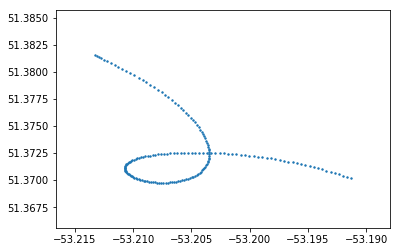

In [9]:
plt.scatter(lons, lats, s=2)

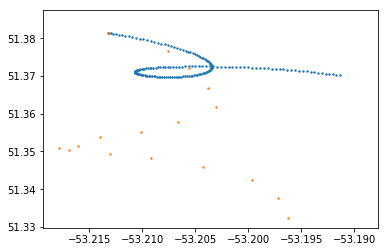

In [12]:
plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2)
plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=2)
plt.show()

In [29]:
def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    force_history = []
    metocean_history = []
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time - time_step:
        
        berg.update_history()

        ax, ay, forces = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))
        
        #print(current_velocity)
        
        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
        
        force_history.append(forces)
        metocean_history.append([current_velocity[0], current_velocity[1], wind_velocity[0], wind_velocity[1]])
        
    force_history = np.array(force_history)
    metocean_history = np.array(metocean_history)
            
    return berg, forces_mat, metocean_history

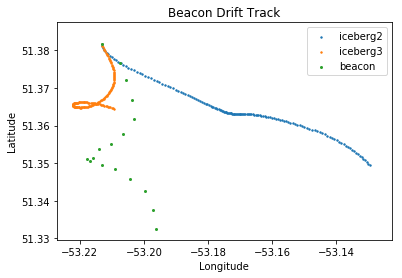

In [38]:
berg2, force_history2, metocean_history2 = drift_wrapper((start_time, start_latitude, 
                                                          start_longitude, start_velocity), 
                                                          meto, time_info, Ca=3, Cw=0.1)

berg3, force_history3, metocean_history3 = drift_wrapper((start_time, start_latitude, 
                                                          start_longitude, start_velocity), 
                                                          meto, time_info, Ca=0.1, Cw=5)

plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

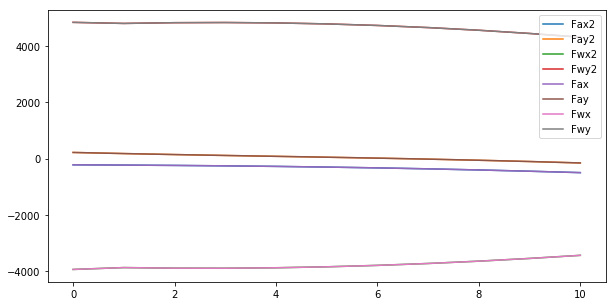

In [39]:
fig = plt.figure(figsize=(10, 5))

plt.plot(force_history2[:, 0], label='Fax2')
plt.plot(force_history2[:, 1], label='Fay2')
plt.plot(force_history2[:, 2], label='Fwx2')
plt.plot(force_history2[:, 3], label='Fwy2')

plt.plot(force_history3[:, 0], label='Fax')
plt.plot(force_history3[:, 1], label='Fay')
plt.plot(force_history3[:, 2], label='Fwx')
plt.plot(force_history3[:, 3], label='Fwy')

plt.legend()
plt.show()


In [35]:
force_history2[0]

array([  -216.27474285,    222.0127781 ,  -3927.92364372,   4837.0230734 ,
       -48224.00600989, -54034.20512337,  34271.66103064,  23887.51415408])

In [36]:
metocean_history2[0]

array([ 0.06229524, -0.10516791,  4.04055391, -0.01615173])

In [24]:
forces_mat2[0]

array([245241.37132684,   4700.22955076,   5486.97381727,   6097.58111934,
       -91461.40714397, -15890.23094921,  39957.90935054,  64715.40355555])

# Optimization

In [8]:
def optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    
    berg, forces_mat = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    try:
        mse = tools.compute_mse((berg.longitude, berg.latitude, berg.time),
                           (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time']),
                           ref_berg.history['time'][0] - np.timedelta64(1,'D'))
    except:
        print(berg2.time)
        raise
    
    return mse


def optimization_wrapper2(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    obs_vecs = (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time'])
    reference_time = ref_berg.history['time'][0] - np.timedelta64(1,'D')
    
    berg, forces_mat = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    mse_list = []
    
    for i in range(len(ref_berg.history['time']) - 1):
        
        j = np.where((berg.history['time'] <= ref_berg.history['time'][i + 1]))[0][-1]
        sim_point = (berg.history['longitude'][j], berg.history['latitude'][j], berg.history['time'][j])
        mse = tools.compute_mse(sim_point, obs_vecs, reference_time)
        mse_list.append(mse)
    
    mse = np.mean(np.array(mse_list))
    
    return mse



callback_mses = []
callback_Cas = []
callback_Cws = []

def callback(x):
    
    result = optimization_wrapper(x, ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info)
    callback_mses.append(result)
    callback_Cas.append(x[0])
    callback_Cws.append(x[1])

In [10]:
optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.02677430158645897
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.15896223e-06, -4.70640887e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 9
   status: 0
  success: True
        x: array([ 0.94699108, 15.        ])

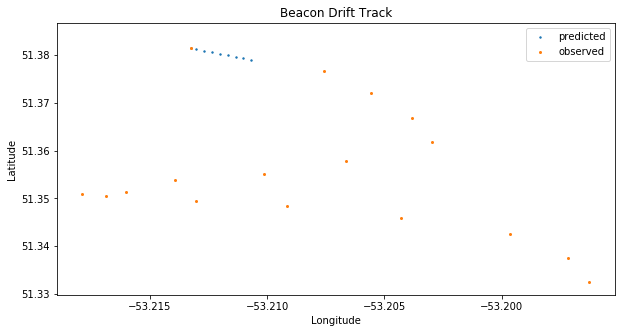

In [17]:
fig = plt.figure(figsize=(10, 5))

berg, forces_mat = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), meto, time_info, 
                                 Ca=optimization_result.x[0], Cw=optimization_result.x[1])

plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2, label='predicted')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='observed')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

## Over progressively longer time scales

In [20]:
del berg
del sub_ref_berg

8.710278747711873e-05 [0.88909182 0.1       ]
0.001213095538107258 [0.1        2.20755209]
0.0033065334598121384 [ 2.57141015 12.        ]
0.005858037258160044 [ 4.24684644 12.        ]
0.007756630289437575 [ 0.1 12. ]
0.008763554000308428 [ 0.1        10.61797521]
0.009581300177706626 [0.1       2.2085455]
0.011783786260784468 [0.1        3.91337667]
0.012627661980537469 [0.1 0.1]
0.013524041938163976 [0.1        4.74334694]
0.015247314188629955 [0.99998875 0.99999586]
0.016850281683903463 [1.00001013 0.99995831]
0.018828427898362924 [0.76354108 0.1       ]
0.020808395770083227 [0.97597743 0.1       ]
0.023309066157895176 [0.98123181 0.1       ]
0.025346286030111343 [1.29637897 0.1       ]


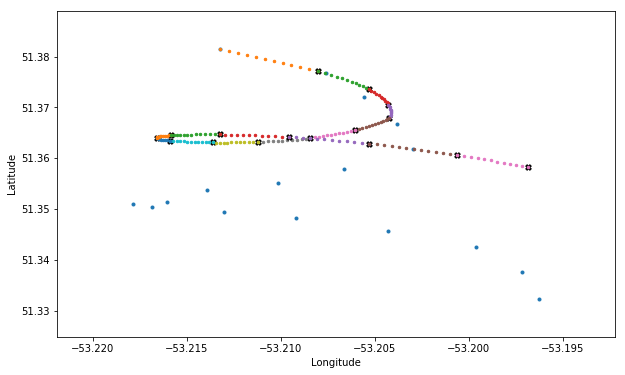

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=9, label='beacon')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


dindx = 1
indxi = -1
indxf = 0

for i in range(1, len(ref_berg.history['time'])):

    indxi += dindx
    indxf += dindx

    sub_ref_berg = copy.deepcopy(ref_berg)
    sub_ref_berg.history['time'] = sub_ref_berg.history['time'][indxi : indxf + 1]
    sub_ref_berg.history['latitude'] = sub_ref_berg.history['latitude'][indxi : indxf + 1]
    sub_ref_berg.history['longitude'] = sub_ref_berg.history['longitude'][indxi : indxf + 1]

    start_time = sub_ref_berg.history['time'][0]
    end_time = sub_ref_berg.history['time'][-1]
    start_latitude = sub_ref_berg.history['latitude'][0]
    start_longitude = sub_ref_berg.history['longitude'][0]
    start_velocity = statoil_data.get_iceberg_velocity_from_dataframe(df, start_index + indxi - 1, 
                                                                      start_index + indxf + 1)
    time_step = np.timedelta64(300, 's')
    time_info = (time_step, end_time)


    if i == 1:

        optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0.1, 12), (0.1, 12)), 
            args=(sub_ref_berg, (start_time, start_latitude, start_longitude, start_velocity), meto, time_info))
        
        print(optimization_result.fun, optimization_result.x)

        berg, forces_mat = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                          meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])
    else:
        start_latitude = berg.latitude
        start_longitude = berg.longitude
        start_velocity = (berg.eastward_velocity, berg.northward_velocity)

        optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0.1, 12), (0.1, 12)), 
            args=(sub_ref_berg, (start_time, start_latitude, start_longitude, start_velocity), meto, time_info))
        
        print(optimization_result.fun, optimization_result.x)

        berg, forces_mat = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                          meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

        
    berg.update_history()

    kberg = np.argmin(abs(berg.history['time'] - end_time))
    plt.scatter(berg.history['longitude'][kberg], berg.history['latitude'][kberg], s=30, marker='X', c='black')
    plt.scatter(berg.history['longitude'], berg.history['latitude'], s=6, label='model')

plt.show()       